<a href="https://colab.research.google.com/github/Armos05/DCE-MRI-data-noise-reduction/blob/main/DL_Ct_denoising_review.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## First Run this

In [11]:
!pip uninstall tensorflow tensorflow-gpu seaborn --yes
!pip install tensorflow-gpu==1.14.0 keras==2.2.5 numpy==1.19.2 seaborn==0.10.1 scipy==1.5.2 scikit-learn==0.23.2 prettytable==1.0.1 wfdb==3.1.1 >> /dev/null

Found existing installation: tensorflow-gpu 1.14.0
Uninstalling tensorflow-gpu-1.14.0:
  Successfully uninstalled tensorflow-gpu-1.14.0
Found existing installation: seaborn 0.10.1
Uninstalling seaborn-0.10.1:
  Successfully uninstalled seaborn-0.10.1


In [ ]:
pip install 'h5py==2.10.0' --force-reinstall

     |████████████████████████████████| 2.9 MB 32.8 MB/s 
     |████████████████████████████████| 15.7 MB 63 kB/s 
  Attempting uninstall: six
    Found existing installation: six 1.15.0
    Uninstalling six-1.15.0:
      Successfully uninstalled six-1.15.0
  Attempting uninstall: numpy
    Found existing installation: numpy 1.19.2
    Uninstalling numpy-1.19.2:
      Successfully uninstalled numpy-1.19.2
  Attempting uninstall: h5py
    Found existing installation: h5py 3.1.0
    Uninstalling h5py-3.1.0:
      Successfully uninstalled h5py-3.1.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
kapre 0.3.5 requires tensorflow>=2.0.0, which is not installed.
google-colab 1.0.0 requires six~=1.15.0, but you have six 1.16.0 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
albumentations 0.1.12 requir

## Loading Data

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd

TrainX = pd.read_csv('drive/MyDrive/TrainXn.csv', header = None)
TrainY = pd.read_csv('drive/MyDrive/TrainY.csv', header = None)
TestX = pd.read_csv('drive/MyDrive/TestXn.csv', header = None)
TestY = pd.read_csv('drive/MyDrive/TestY.csv', header = None)

In [ ]:
print(TrainX.shape, TrainY.shape, TestX.shape, TestY.shape)

Train_x = TrainX.T
Train_y = TrainY.T
Test_x = TestX.T
Test_y = TestY.T
print(Train_x.shape, Train_y.shape, Test_x.shape, Test_y.shape)

Train_x = Train_x.to_numpy()
Train_y = Train_y.to_numpy()
Test_x = Test_x.to_numpy()
Test_y = Test_y.to_numpy()
print(Train_x.shape, Train_y.shape, Test_x.shape, Test_y.shape)

from numpy import zeros, newaxis

# a[:, :, newaxis]
Train_x = Train_x[:,:,newaxis]
Train_y = Train_y[:,:,newaxis]
Test_x = Test_x[:,:,newaxis]
Test_y = Test_y[:,:,newaxis]
print(Train_x.shape, Train_y.shape, Test_x.shape, Test_y.shape)

X_train = Train_x 
y_train = Train_y
X_test = Test_x
y_test = Test_y

Dataset = [X_train, y_train, X_test, y_test]


(512, 72002) (512, 72002) (512, 13316) (512, 13316)
(72002, 512) (72002, 512) (13316, 512) (13316, 512)
(72002, 512) (72002, 512) (13316, 512) (13316, 512)
(72002, 512, 1) (72002, 512, 1) (13316, 512, 1) (13316, 512, 1)


In [ ]:
import numpy as np

X_train = X_train[1:20001]
y_train = y_train[1:20001]
X_test = X_test[1:5001]
y_test = y_test[1:5001]

Dataset = [X_train, y_train, X_test, y_test]

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(20000, 512, 1) (20000, 512, 1) (5000, 512, 1) (5000, 512, 1)


## Define Metric Function

In [2]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

def SSD(y, y_pred):
    return np.sum(np.square(y - y_pred), axis=1)  # axis 1 is the signal dimension


def MAD(y, y_pred):
    return np.max(np.abs(y - y_pred), axis=1) # axis 1 is the signal dimension


def PRD(y, y_pred):
    N = np.sum(np.square(y_pred - y), axis=1)
    D = np.sum(np.square(y_pred - np.mean(y)), axis=1)

    PRD = np.sqrt(N/D) * 100

    return PRD


def COS_SIM(y, y_pred):
    cos_sim = []

    y = np.squeeze(y, axis=-1)
    y_pred = np.squeeze(y_pred, axis=-1)

    for idx in range(len(y)):
        kl_temp = cosine_similarity(y[idx].reshape(1, -1), y_pred[idx].reshape(1, -1))
        cos_sim.append(kl_temp)

    cos_sim = np.array(cos_sim)
    return cos_sim

## Visualization

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from prettytable import PrettyTable

def generate_table(metrics, metric_values, Exp_names):
    # Print tabular results in the console, in a pretty way
    print('\n')

    tb = PrettyTable()
    ind = 0

    for exp_name in Exp_names:

        tb.field_names = ['Method/Model'] + metrics

        tb_row = []
        tb_row.append(exp_name)

        for metric in metric_values:   # metric_values[metric][model][beat]
            m_mean = np.mean(metric[ind])
            m_std = np.std(metric[ind])
            tb_row.append('{:.3f}'.format(m_mean) + ' (' + '{:.3f}'.format(m_std) + ')')

        tb.add_row(tb_row)
        ind += 1

    print(tb)

def generate_table_time(column_names, all_values, Exp_names, gpu=True):
    # Print tabular results in the console, in a pretty way

    # The FIR and IIR are the last on all_values
    # We need circular shift them to the right
    all_values[0] = all_values[0][-2::] + all_values[0][0:-2]
    all_values[1] = all_values[1][-2::] + all_values[1][0:-2]

    print('\n')

    tb = PrettyTable()
    ind = 0

    if gpu:
        device = 'GPU'
    else:
        device = 'CPU'

    for exp_name in Exp_names:
        tb.field_names = ['Method/Model'] + [column_names[0] + '(' + device + ') h:m:s:ms'] + [
            column_names[1] + '(' + device + ') h:m:s:ms']

        tb_row = []
        tb_row.append(exp_name)
        tb_row.append(all_values[0][ind])
        tb_row.append(all_values[1][ind])

        tb.add_row(tb_row)

        ind += 1

    print(tb)

    if gpu:
        print('* For FIR and IIR Filters is CPU since scipy filters are CPU based implementations')

def generate_hboxplot(np_data, description, ylabel, log, set_x_axis_size=None):
    # Process the results and store in Panda objects
    col = description
    loss_val_np = np.rot90(np_data)

    pd_df = pd.DataFrame.from_records(loss_val_np, columns=col)

    # Set up the matplotlib figure
    sns.set(style="whitegrid")

    f, ax = plt.subplots(figsize=(15, 6))

    ax = sns.boxplot(data=pd_df, orient="h", width=0.4)

    if log:
        ax.set_xscale("log")

    if set_x_axis_size != None:
        ax.set_xlim(set_x_axis_size)

    ax.set(ylabel='Models/Methods', xlabel=ylabel)
    ax = sns.despine(left=True, bottom=True)

    plt.show()


def ecg_view(ecg, ecg_blw, ecg_dl, ecg_f, signal_name=None, beat_no=None):

    fig, ax = plt.subplots(figsize=(16, 9))
    plt.plot(ecg_blw, 'k', label='ECG + BLW')
    plt.plot(ecg, 'g', label='ECG orig')
    plt.plot(ecg_dl, 'b', label='ECG DL Filtered')
    plt.plot(ecg_f, 'r', label='ECG IIR Filtered')
    plt.grid(True)

    plt.ylabel('au')
    plt.xlabel('samples')

    leg = ax.legend()

    if signal_name != None and beat_no != None:
        plt.title('Signal ' + str(signal_name) + 'beat ' + str(beat_no))
    else:
        plt.title('ECG signal for comparison')

    plt.show()

def ecg_view_diff(ecg, ecg_blw, ecg_dl, ecg_f, signal_name=None, beat_no=None):

    fig, ax = plt.subplots(figsize=(16, 9))
    plt.plot(ecg, 'g', label='ECG orig')
    plt.plot(ecg_dl, 'b', label='ECG DL Filtered')
    plt.plot(ecg_f, 'r', label='ECG IIR Filtered')
    plt.plot(ecg - ecg_dl, color='#0099ff', lw=3, label='Difference ECG - DL Filter')
    plt.plot(ecg - ecg_f, color='#cb828d', lw=3, label='Difference ECG - IIR Filter')
    plt.grid(True)

    plt.ylabel('Amplitude (au)')
    plt.xlabel('samples')

    leg = ax.legend()

    if signal_name != None and beat_no != None:
        plt.title('Signal ' + str(signal_name) + 'beat ' + str(beat_no))
    else:
        plt.title('ECG signal for comparison')

    plt.show()

## Classic Digital Filters

In [15]:
import scipy.io as sio
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import kaiserord, firwin, filtfilt, butter


def FIRRemoveBL(ecgy, Fs, Fc, factor):
    
    #    ecgy:        the contamined signal (must be a list)
    #    Fc:          cut-off frequency
    #    Fs:          sample frequiency
    #    ECG_Clean :  processed signal without BLW
    
    # getting the length of the signal
    signal_len = len(ecgy)
    
    # The Nyquist rate of the signal.
    nyq_rate = Fs / 2.0
    
    # The desired width of the transition from stop to pass,
    # relative to the Nyquist rate. 
    width = 0.07/nyq_rate 
    
    # Attenuation in the stop band, in dB.
    # related to devs in Matlab. On Matlab is on proportion
    ripple_db = round(-20*np.log10(0.001))+1
    ripple_db = ripple_db / factor

    
    # Compute the order and Kaiser parameter for the FIR filter.
    N, beta = kaiserord(ripple_db, width)
       
    # Use firwin with a Kaiser window to create a highpass FIR filter.
    h = firwin(N, Fc/nyq_rate, window=('kaiser', beta), pass_zero='highpass')

    # Check filtfilt condition
    if N*3 > signal_len:
        diff = N*3 - signal_len
        ecgy = list(reversed(ecgy)) + list(ecgy) + list(ecgy[-1] * np.ones(diff))
        
        # Filtering with filtfilt
        ECG_Clean = filtfilt(h, 1.0, ecgy)
        ECG_Clean = ECG_Clean[signal_len: signal_len + signal_len]
    else:
        ECG_Clean = filtfilt(h, 1.0, ecgy)
    
    return ECG_Clean, N


def FIRRemoveHF(ecgy, Fs, Fc, factor):
    #    ecgy:        the contamined signal (must be a list)
    #    Fc:          cut-off frequency
    #    Fs:          sample frequiency
    #    ECG_Clean :  processed signal without BLW

    # getting the length of the signal
    signal_len = len(ecgy)

    # The Nyquist rate of the signal.
    nyq_rate = Fs / 2.0

    # The desired width of the transition from stop to pass,
    # relative to the Nyquist rate.
    width = 0.07 / nyq_rate

    # Attenuation in the stop band, in dB.
    # related to devs in Matlab. On Matlab is on proportion
    ripple_db = round(-20 * np.log10(0.001)) + 1
    ripple_db = ripple_db / factor

    # Compute the order and Kaiser parameter for the FIR filter.
    N, beta = kaiserord(ripple_db, width)

    # Use firwin with a Kaiser window to create a highpass FIR filter.
    h = firwin(N, Fc / nyq_rate, window=('kaiser', beta), pass_zero='lowpass')

    # Check filtfilt condition
    if N * 3 > signal_len:
        diff = N * 3 - signal_len
        ecgy = list(reversed(ecgy)) + list(ecgy) + list(ecgy[-1] * np.ones(diff))

        # Filtering with filtfilt
        ECG_Clean = filtfilt(h, 1.0, ecgy)
        ECG_Clean = ECG_Clean[signal_len: signal_len + signal_len]
    else:
        ECG_Clean = filtfilt(h, 1.0, ecgy)

    return ECG_Clean, N

def IIRRemoveBL(ecgy,Fs, Fc):
    
    #    ecgy:        the contamined signal (must be a list)
    #    Fc:          cut-off frequency
    #    Fs:          sample frequiency
    #    ECG_Clean :  processed signal without BLW
    
    # getting the length of the signal
    signal_len = len(ecgy)
    
    # fixed order
    N = 4
    
    # Normalized Cutt of frequency
    Wn = Fc/(Fs/2)    
    
    # IIR butterworth coefficients
    b, a = butter(N, Wn, 'highpass', analog=False)
    
    # Check filtfilt condition
    if N*3 > signal_len:
        diff = N*3 - signal_len
        ecgy = list(reversed(ecgy)) + list(ecgy) + list(ecgy[-1] * np.ones(diff))
        
        # Filtering with filtfilt
        ECG_Clean = filtfilt(b, a, ecgy)
        ECG_Clean = ECG_Clean[signal_len: signal_len + signal_len]
        
    else:
        ECG_Clean = filtfilt(b, a, ecgy)
                   
    return ECG_Clean


def IIRRemoveHF(ecgy, Fs, Fc):
    #    ecgy:        the contamined signal (must be a list)
    #    Fc:          cut-off frequency
    #    Fs:          sample frequiency
    #    ECG_Clean :  processed signal without BLW

    # getting the length of the signal
    signal_len = len(ecgy)

    # fixed order
    N = 4

    # Normalized Cutt of frequency
    Wn = Fc / (Fs / 2)

    # IIR butterworth coefficients
    b, a = butter(N, Wn, 'lowpass', analog=False)

    # Check filtfilt condition
    if N * 3 > signal_len:
        diff = N * 3 - signal_len
        ecgy = list(reversed(ecgy)) + list(ecgy) + list(ecgy[-1] * np.ones(diff))

        # Filtering with filtfilt
        ECG_Clean = filtfilt(b, a, ecgy)
        ECG_Clean = ECG_Clean[signal_len: signal_len + signal_len]

    else:
        ECG_Clean = filtfilt(b, a, ecgy)

    return ECG_Clean


def FIR_test_Dataset(Dataset):
    [train_set, train_set_GT, X_test, y_test] = Dataset

    ## parameters
    Fs = 360
    Fc_l = 0.67
    Fc_h = 150.0

    y_filter_out = []

    current_signal = 0

    for signal in X_test:
        current_signal += 1
        #print('(FIR) Filtering signal ' + str(current_signal) + ' of ' + str(len(X_test)))
        s = np.squeeze(signal, axis=1).tolist()

        temp_signal, N = FIRRemoveBL(s, Fs, Fc_l, 4.5)
        temp_signal, N = FIRRemoveHF(temp_signal, Fs, Fc_h, 4.5)

        y_filter_out.append(temp_signal)

    y_filter_out = np.expand_dims(np.array(y_filter_out), axis=2)

    return [X_test, y_test, y_filter_out]


def IIR_test_Dataset(Dataset):
    [train_set, train_set_GT, X_test, y_test] = Dataset

    ## parameters
    Fs = 360
    Fc_l = 0.67
    Fc_h = 150.0

    y_filter_out = []

    current_signal = 0

    for signal in X_test:
        current_signal += 1
        #print('(IIR) Filtering signal ' + str(current_signal) + ' of ' + str(len(X_test)))
        s = np.squeeze(signal, axis=1).tolist()

        temp_signal = IIRRemoveBL(s, Fs, Fc_l)
        temp_signal = IIRRemoveHF(temp_signal, Fs, Fc_h)

        y_filter_out.append(temp_signal)

    y_filter_out = np.expand_dims(np.array(y_filter_out), axis=2)

    return [X_test, y_test, y_filter_out]

## Deep Learning Models

In [ ]:
import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Conv1D, Flatten, Dropout, BatchNormalization, concatenate, Activation, Add, Input, Conv2DTranspose, Lambda, LSTM, Reshape, Embedding, AvgPool1D, LeakyReLU, Flatten
from keras.initializers import glorot_uniform
import keras.backend as K

def Conv1DTranspose(input_tensor, filters, kernel_size, strides=2, activation='relu', padding='same'):
    """
        https://stackoverflow.com/a/45788699

        input_tensor: tensor, with the shape (batch_size, time_steps, dims)
        filters: int, output dimension, i.e. the output tensor will have the shape of (batch_size, time_steps, filters)
        kernel_size: int, size of the convolution kernel
        strides: int, convolution step size
        padding: 'same' | 'valid'
    """
    x = Lambda(lambda x: K.expand_dims(x, axis=2))(input_tensor)
    x = Conv2DTranspose(filters=filters,
                        kernel_size=(kernel_size, 1),
                        activation=activation,
                        strides=(strides, 1),
                        padding=padding)(x)
    x = Lambda(lambda x: K.squeeze(x, axis=2))(x)
    return x

##########################################################################

###### MODULES #######

def LFilter_module(x, layers):
    LB0 = Conv1D(filters=int(layers / 4),
                 kernel_size=3,
                 activation='linear',
                 strides=1,
                 padding='same')(x)
    LB1 = Conv1D(filters=int(layers / 4),
                kernel_size=5,
                activation='linear',
                strides=1,
                padding='same')(x)
    LB2 = Conv1D(filters=int(layers / 4),
                kernel_size=9,
                activation='linear',
                strides=1,
                padding='same')(x)
    LB3 = Conv1D(filters=int(layers / 4),
                kernel_size=15,
                activation='linear',
                strides=1,
                padding='same')(x)


    x = concatenate([LB0, LB1, LB2, LB3])

    return x


def NLFilter_module(x, layers):

    NLB0 = Conv1D(filters=int(layers / 4),
                  kernel_size=3,
                  activation='relu',
                  strides=1,
                  padding='same')(x)
    NLB1 = Conv1D(filters=int(layers / 4),
                kernel_size=5,
                activation='relu',
                strides=1,
                padding='same')(x)
    NLB2 = Conv1D(filters=int(layers / 4),
                kernel_size=9,
                activation='relu',
                strides=1,
                padding='same')(x)
    NLB3 = Conv1D(filters=int(layers / 4),
                kernel_size=15,
                activation='relu',
                strides=1,
                padding='same')(x)


    x = concatenate([NLB0, NLB1, NLB2, NLB3])

    return x


def LANLFilter_module(x, layers):
    LB0 = Conv1D(filters=int(layers / 8),
                 kernel_size=3,
                 activation='linear',
                 strides=1,
                 padding='same')(x)
    LB1 = Conv1D(filters=int(layers / 8),
                kernel_size=5,
                activation='linear',
                strides=1,
                padding='same')(x)
    LB2 = Conv1D(filters=int(layers / 8),
                kernel_size=9,
                activation='linear',
                strides=1,
                padding='same')(x)
    LB3 = Conv1D(filters=int(layers / 8),
                kernel_size=15,
                activation='linear',
                strides=1,
                padding='same')(x)

    NLB0 = Conv1D(filters=int(layers / 8),
                  kernel_size=3,
                  activation='relu',
                  strides=1,
                  padding='same')(x)
    NLB1 = Conv1D(filters=int(layers / 8),
                 kernel_size=5,
                 activation='relu',
                 strides=1,
                 padding='same')(x)
    NLB2 = Conv1D(filters=int(layers / 8),
                 kernel_size=9,
                 activation='relu',
                 strides=1,
                 padding='same')(x)
    NLB3 = Conv1D(filters=int(layers / 8),
                 kernel_size=15,
                 activation='relu',
                 strides=1,
                 padding='same')(x)

    x = concatenate([LB0, LB1, LB2, LB3, NLB0, NLB1, NLB2, NLB3])

    return x


def LANLFilter_module_dilated(x, layers):
    LB1 = Conv1D(filters=int(layers / 6),
                kernel_size=5,
                activation='linear',
                dilation_rate=3,
                padding='same')(x)
    LB2 = Conv1D(filters=int(layers / 6),
                kernel_size=9,
                activation='linear',
                dilation_rate=3,
                padding='same')(x)
    LB3 = Conv1D(filters=int(layers / 6),
                kernel_size=15,
                dilation_rate=3,
                activation='linear',
                padding='same')(x)

    NLB1 = Conv1D(filters=int(layers / 6),
                 kernel_size=5,
                 activation='relu',
                 dilation_rate=3,
                 padding='same')(x)
    NLB2 = Conv1D(filters=int(layers / 6),
                 kernel_size=9,
                 activation='relu',
                 dilation_rate=3,
                 padding='same')(x)
    NLB3 = Conv1D(filters=int(layers / 6),
                 kernel_size=15,
                 dilation_rate=3,
                 activation='relu',
                 padding='same')(x)

    x = concatenate([LB1, LB2, LB3, NLB1, NLB2, NLB3])
    # x = BatchNormalization()(x)

    return x


###### MODELS #######

def deep_filter_vanilla_linear():

    model = Sequential()

    model.add(Conv1D(filters=64,
                     kernel_size=9,
                     activation='linear',
                     input_shape=(512, 1),
                     strides=1,
                     padding='same'))
    model.add(Conv1D(filters=64,
                     kernel_size=9,
                     activation='linear',
                     strides=1,
                     padding='same'))


    model.add(Conv1D(filters=32,
                     kernel_size=9,
                     activation='linear',
                     strides=1,
                     padding='same'))
    model.add(Conv1D(filters=32,
                     kernel_size=9,
                     activation='linear',
                     strides=1,
                     padding='same'))


    model.add(Conv1D(filters=16,
                     kernel_size=9,
                     activation='linear',
                     strides=1,
                     padding='same'))
    model.add(Conv1D(filters=16,
                     kernel_size=9,
                     activation='linear',
                     strides=1,
                     padding='same'))


    model.add(Conv1D(filters=1,
                     kernel_size=9,
                     activation='linear',
                     strides=1,
                     padding='same'))
    return model


def deep_filter_vanilla_Nlinear():
    model = Sequential()

    model.add(Conv1D(filters=64,
                     kernel_size=9,
                     activation='relu',
                     input_shape=(512, 1),
                     strides=1,
                     padding='same'))
    model.add(Conv1D(filters=64,
                     kernel_size=9,
                     activation='relu',
                     strides=1,
                     padding='same'))


    model.add(Conv1D(filters=32,
                     kernel_size=9,
                     activation='relu',
                     strides=1,
                     padding='same'))
    model.add(Conv1D(filters=32,
                     kernel_size=9,
                     activation='relu',
                     strides=1,
                     padding='same'))


    model.add(Conv1D(filters=16,
                     kernel_size=9,
                     activation='relu',
                     strides=1,
                     padding='same'))
    model.add(Conv1D(filters=16,
                     kernel_size=9,
                     activation='relu',
                     strides=1,
                     padding='same'))


    model.add(Conv1D(filters=1,
                     kernel_size=9,
                     activation='linear',
                     strides=1,
                     padding='same'))
    return model


def deep_filter_I_linear():
    input_shape = (512, 1)
    input = Input(shape=input_shape)

    tensor = LFilter_module(input, 64)
    tensor = LFilter_module(tensor, 64)
    tensor = LFilter_module(tensor, 32)
    tensor = LFilter_module(tensor, 32)
    tensor = LFilter_module(tensor, 16)
    tensor = LFilter_module(tensor, 16)
    predictions = Conv1D(filters=1,
                         kernel_size=9,
                         activation='linear',
                         strides=1,
                         padding='same')(tensor)

    model = Model(inputs=[input], outputs=predictions)

    return model


def deep_filter_I_Nlinear():
    input_shape = (512, 1)
    input = Input(shape=input_shape)

    tensor = NLFilter_module(input, 64)
    tensor = NLFilter_module(tensor, 64)
    tensor = NLFilter_module(tensor, 32)
    tensor = NLFilter_module(tensor, 32)
    tensor = NLFilter_module(tensor, 16)
    tensor = NLFilter_module(tensor, 16)
    predictions = Conv1D(filters=1,
                         kernel_size=9,
                         activation='linear',
                         strides=1,
                         padding='same')(tensor)

    model = Model(inputs=[input], outputs=predictions)

    return model


def deep_filter_I_LANL():
    # TODO: Make the doc

    input_shape = (512, 1)
    input = Input(shape=input_shape)

    tensor = LANLFilter_module(input, 64)
    tensor = BatchNormalization()(tensor)
    tensor = LANLFilter_module(tensor, 64)
    tensor = BatchNormalization()(tensor)
    tensor = LANLFilter_module(tensor, 32)
    tensor = BatchNormalization()(tensor)
    tensor = LANLFilter_module(tensor, 32)
    tensor = BatchNormalization()(tensor)
    tensor = LANLFilter_module(tensor, 16)
    tensor = BatchNormalization()(tensor)
    tensor = LANLFilter_module(tensor, 16)
    tensor = BatchNormalization()(tensor)
    predictions = Conv1D(filters=1,
                    kernel_size=9,
                    activation='linear',
                    strides=1,
                    padding='same')(tensor)

    model = Model(inputs=[input], outputs=predictions)

    return model


def deep_filter_model_I_LANL_dilated():
    # TODO: Make the doc

    input_shape = (512, 1)
    input = Input(shape=input_shape)

    tensor = LANLFilter_module(input, 64)
    tensor = BatchNormalization()(tensor)
    tensor = LANLFilter_module_dilated(tensor, 64)
    tensor = BatchNormalization()(tensor)
    tensor = LANLFilter_module(tensor, 32)
    tensor = BatchNormalization()(tensor)
    tensor = LANLFilter_module_dilated(tensor, 32)
    tensor = BatchNormalization()(tensor)
    tensor = LANLFilter_module(tensor, 16)
    tensor = BatchNormalization()(tensor)
    tensor = LANLFilter_module_dilated(tensor, 16)
    tensor = BatchNormalization()(tensor)
    predictions = Conv1D(filters=1,
                    kernel_size=9,
                    activation='linear',
                    strides=1,
                    padding='same')(tensor)

    model = Model(inputs=[input], outputs=predictions)

    return model


def FCN_DAE():
    # Implementation of FCN_DAE approach presented in
    # Chiang, H. T., Hsieh, Y. Y., Fu, S. W., Hung, K. H., Tsao, Y., & Chien, S. Y. (2019).
    # Noise reduction in ECG signals using fully convolutional denoising autoencoders.
    # IEEE Access, 7, 60806-60813.

    input_shape = (512, 1)
    input = Input(shape=input_shape)

    x = Conv1D(filters=40,
               input_shape=(512, 1),
               kernel_size=16,
               activation='elu',
               strides=2,
               padding='same')(input)

    x = BatchNormalization()(x)  #256,40

    x = Conv1D(filters=20,
               kernel_size=16,
               activation='elu',
               strides=2,
               padding='same')(x)

    x = BatchNormalization()(x)  #128, 20

    x = Conv1D(filters=20,
               kernel_size=16,
               activation='elu',
               strides=2,
               padding='same')(x)

    x = BatchNormalization()(x)  #64, 20

    x = Conv1D(filters=20,
               kernel_size=16,
               activation='elu',
               strides=2,
               padding='same')(x)

    x = BatchNormalization()(x)  #32, 20

    x = Conv1D(filters=40,
               kernel_size=16,
               activation='elu',
               strides=2,
               padding='same')(x)

    x = BatchNormalization()(x) #16, 40

    x = Conv1D(filters=1,
               kernel_size=16,
               activation='elu',
               strides=1,
               padding='same')(x)

    x = BatchNormalization()(x) #16, 1

    # Keras has no 1D Traspose Convolution, instead we use Conv2DTranspose function
    # in a souch way taht is mathematically equivalent
    x = Conv1DTranspose(input_tensor=x,
                        filters=1,
                        kernel_size=16,
                        activation='elu',
                        strides=1,
                        padding='same')

    x = BatchNormalization()(x)  #16, 1

    x = Conv1DTranspose(input_tensor=x,
                        filters=40,
                        kernel_size=16,
                        activation='elu',
                        strides=2,
                        padding='same') 

    x = BatchNormalization()(x)    #32, 40

    x = Conv1DTranspose(input_tensor=x,
                        filters=20,
                        kernel_size=16,
                        activation='elu',
                        strides=2,
                        padding='same')

    x = BatchNormalization()(x)   #64, 20

    x = Conv1DTranspose(input_tensor=x,
                        filters=20,
                        kernel_size=16,
                        activation='elu',
                        strides=2,
                        padding='same')

    x = BatchNormalization()(x)  #128, 20

    x = Conv1DTranspose(input_tensor=x,
                        filters=20,
                        kernel_size=16,
                        activation='elu',
                        strides=2,
                        padding='same')

    x = BatchNormalization()(x)   #256, 20

    x = Conv1DTranspose(input_tensor=x,
                        filters=40,
                        kernel_size=16,
                        activation='elu',
                        strides=2,
                        padding='same')

    x = BatchNormalization()(x)  #512, 40

    predictions = Conv1DTranspose(input_tensor=x,
                        filters=1,
                        kernel_size=16,
                        activation='linear',
                        strides=1,
                        padding='same')  #512, 1

    model = Model(inputs=[input], outputs=predictions)
    return model


def DRRN_denoising():
    # Implementation of DRNN approach presented in
    # Antczak, K. (2018). Deep recurrent neural networks for ECG signal denoising.
    # arXiv preprint arXiv:1807.11551.    

    model = Sequential()
    model.add(LSTM(64, input_shape=(512, 1), return_sequences=True))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1, activation='linear'))

    return model

def LSTM_denoising():
    # Implementation of LSTM approach presented in
    # Deep Learning Models for Denoising ECG Signals Corneliu T.C. Arsene, Richard Hankins, Hujun Yin
    # https://ieeexplore.ieee.org/document/8902833

    model = Sequential()
    model.add(LSTM(140, input_shape=(512, 1), return_sequences=True))
    model.add(Dense(140, activation='relu'))
    model.add(LSTM(140, return_sequences=True)) #Check for errors
    model.add(Dense(140, activation='relu'))
    model.add(Dense(1, activation='linear'))

    return model

def CNN_Denoising():
    # Implementation of CNN denoising approach presented in
    # Deep Learning Models for Denoising ECG Signals Corneliu T.C. Arsene, Richard Hankins, Hujun Yin
    # https://ieeexplore.ieee.org/document/8902833
    
  input_shape = (512,1)
  input = Input(shape = input_shape)
  

  x = Conv1D(filters=36, input_shape=(512,1), kernel_size=19, activation='relu',strides = 1, padding = "same")(input)
  x = BatchNormalization()(x)
  leaky_relu = LeakyReLU(alpha=0.01)
  x = Activation(leaky_relu)(x)
  x = AvgPool1D(pool_size=2, strides=4, padding="same")(x) #128,36
  
  x = Conv1D(filters=36, kernel_size=19, activation='relu', input_shape=(512,1), padding = "same")(x)
  x = BatchNormalization()(x)
  leaky_relu = LeakyReLU(alpha=0.01)
  x = Activation(leaky_relu)(x)
  x = AvgPool1D(pool_size=2, strides=4, padding="same")(x) #32,36

  x = Conv1D(filters=36, kernel_size=19, activation='relu', input_shape=(512,1), padding = "same")(x)
  x = BatchNormalization()(x)
  leaky_relu = LeakyReLU(alpha=0.01)
  x = Activation(leaky_relu)(x)
  x = AvgPool1D(pool_size=2, strides=4, padding="same")(x) #8,36

  x= Flatten()(x) #288

  predictions = Dense(512, activation='linear')(x) # 512

  predictions = Lambda(lambda i: K.expand_dims(i, axis=2))(predictions)
  
  model = Model(inputs=[input], outputs=predictions)

  return model


def CNN_encoder_decoder():
    # Implementation of CNN autoencoder for denoising approach presented in
    # End-to-End Trained CNN Encoder-Decoder Network for Fetal ECG Signal Denoising
    # https://iopscience.iop.org/article/10.1088/1361-6579/ab69b9/meta
    # https://github.com/rshnn/xray-denoising


    input_shape = (512,1)
    input = Input(shape = input_shape)

    x = Conv1D(filters=64, kernel_size=15, padding='same', kernel_initializer=glorot_uniform(seed=0))(input)
    leaky_relu = LeakyReLU(alpha=0.01)
    x = BatchNormalization()(x)
    x = Activation(leaky_relu)(x)   #512, 64
    
    shortcut_1 = x #512,64

    x = Conv1D(filters=128, kernel_size=15, strides = 2, padding='same', kernel_initializer=glorot_uniform(seed=0))(x)
    x = BatchNormalization()(x)
    x = Activation(leaky_relu)(x) #256 128
    
    shortcut_2 = x #256, 128

    x = Conv1D(filters=256, kernel_size=15, strides=2, padding='same', 
               kernel_initializer=glorot_uniform(seed=0))(x)
    x = BatchNormalization()(x)
    x = Activation(leaky_relu)(x) #128,256
    
    shortcut_3 = x #128, 256

    x = Conv1D(filters=256, kernel_size=15, strides=2, padding='same', 
               kernel_initializer=glorot_uniform(seed=0))(x)
    x = BatchNormalization()(x)
    x = Activation(leaky_relu)(x) #64,256
    
    shortcut_4 = x #64, 256

    x = Conv1D(filters= 512, kernel_size=15, strides=2, padding='same', 
               kernel_initializer=glorot_uniform(seed=0))(x)
    x = BatchNormalization()(x)
    x = Activation(leaky_relu)(x) #32,512

    shortcut_5 = x #32, 512

    x = Conv1D(filters=512, kernel_size=15 , strides=2, padding='same', 
               kernel_initializer=glorot_uniform(seed=0))(x)
    x = BatchNormalization()(x)
    x = Activation(leaky_relu)(x) #16,512

    shortcut_6 = x  #16, 512

    x = Conv1D(filters=1024, kernel_size=15, strides=2, padding='same', 
               kernel_initializer=glorot_uniform(seed=0))(x)
    x = Activation(leaky_relu)(x) #8, 1024

    shortcut_7 = x #8, 1024

    x = Conv1D(filters=2048, kernel_size=15,strides=2, padding='same', 
               kernel_initializer=glorot_uniform(seed=0))(x)
    x = BatchNormalization()(x)
    x = Activation(leaky_relu)(x) #4,2048


    
    ## Upsampling 
    x = Conv1DTranspose(input_tensor = x, filters=2048, kernel_size=15, strides=1, padding='same')
    x = BatchNormalization()(x)
    x = Activation(leaky_relu)(x) #4,2048

    x = Conv1DTranspose(input_tensor = x, filters=1024, kernel_size=15, strides=2, padding='same')
    x = BatchNormalization()(x)
    x = Activation(leaky_relu)(x) #8,1024

    x = Add()([x, shortcut_7]) #8, 1024
    x = Conv1DTranspose(input_tensor = x,filters=512, kernel_size=15, strides=2, padding='same')
    x = BatchNormalization()(x)
    x = Activation(leaky_relu)(x) #16, 512

    x = Add()([x, shortcut_6]) #16, 512
    x = Conv1DTranspose(input_tensor = x,filters=512, kernel_size=15, strides=2, padding='same')
    x = BatchNormalization()(x)
    x = Activation(leaky_relu)(x) #32, 512

    x = Add()([x, shortcut_5]) #32, 512
    x = Conv1DTranspose(input_tensor = x, filters=256, kernel_size=15, strides=2, padding='same')
    x = BatchNormalization()(x)
    x = Activation(leaky_relu)(x) #64, 256

    x = Add()([x, shortcut_4]) #64, 256
    x = Conv1DTranspose(input_tensor = x, filters=256, strides = 2, kernel_size=15, padding='same')
    x = BatchNormalization()(x)
    x = Activation(leaky_relu)(x) #128, 256  

    x = Add()([x, shortcut_3]) #128,256
    x = Conv1DTranspose(input_tensor = x, filters=128, kernel_size=15, strides=2, padding='same')
    x = BatchNormalization()(x)
    x = Activation(leaky_relu)(x) #256, 128

    x = Add()([x, shortcut_2]) #256, 128
    x = Conv1DTranspose(input_tensor = x, filters=64, kernel_size=15, strides=2, padding='same')
    x = BatchNormalization()(x)
    x = Activation(leaky_relu)(x) # 512,64

    x = Add()([x, shortcut_1]) 
    predictions = Conv1DTranspose(input_tensor = x, filters=1, kernel_size=15, strides=1, padding='same', activation = 'relu') #512,1

    model = Model(inputs=[input], outputs=predictions)
    return model

Using TensorFlow backend.
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarn

## Deep Learning Pipilines

In [ ]:
import keras
from keras import backend as K
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, TensorBoard
from keras import losses
from sklearn.model_selection import train_test_split

# Custom loss SSD
def ssd_loss(y_true, y_pred):
    return K.sum(K.square(y_pred - y_true), axis=-2)

# Combined loss SSD + MSE
def combined_ssd_mse_loss(y_true, y_pred):
    return K.mean(K.square(y_true - y_pred), axis=-2) * 500 + K.sum(K.square(y_true - y_pred), axis=-2)

def combined_ssd_mad_loss(y_true, y_pred):
    return K.max(K.square(y_true - y_pred), axis=-2) * 50 + K.sum(K.square(y_true - y_pred), axis=-2)

# Custom loss SAD
def sad_loss(y_true, y_pred):
    return K.sum(K.sqrt(K.square(y_pred - y_true)), axis=-2)

# Custom loss MAD
def mad_loss(y_true, y_pred):
    return K.max(K.square(y_pred - y_true), axis=-2)


def train_dl(Dataset, experiment):

    print('Deep Learning pipeline: Training the model for exp ' + str(experiment))

    [X_train, y_train, X_test, y_test] = Dataset

    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3, shuffle=True, random_state=1)

    # ==================
    # LOAD THE DL MODEL
    # ==================


    if experiment == 'FCN-DAE':
        # FCN_DAE
        model = FCN_DAE()
        model_label = 'FCN_DAE'

    if experiment == 'DRNN':
        # DRNN
        model = DRRN_denoising()
        model_label = 'DRNN'

    if experiment == 'Vanilla L':
        # Vanilla CNN linear
        model = deep_filter_vanilla_linear()
        model_label = 'Vanilla_L'

    if experiment == 'Vanilla NL':
        # Vanilla CNN non linear
        model = deep_filter_vanilla_Nlinear()
        model_label = 'Vanilla_NL'    

    if experiment == 'Multibranch LANL':
        # Multibranch linear and non linear
        model = deep_filter_I_LANL()
        model_label = 'Multibranch_LANL'

    if experiment == 'Multibranch LANLD':
        # Inception-like linear and non linear dilated
        model = deep_filter_model_I_LANL_dilated()
        model_label = 'Multibranch_LANLD'

    if experiment == 'LSTM IEEE':
        # LSTM IEEE
        model = LSTM_denoising()
        model_label = 'LSTM_IEEE'

    if experiment == 'CNN IEEE':
        # CNN IEEE
        model = CNN_Denoising()
        model_label = 'CNN_IEEE'

    if experiment == 'CNN autoencoder':
        # CNN encoder decoder
        model = CNN_encoder_decoder()
        model_label = 'CNN_autoencoder'


    print('\n ' + model_label + '\n ')

    model.summary()

    epochs = int(1e5)  # 100000
    # epochs = 100
    batch_size = 128
    lr = 1e-3
    # lr = 1e-4
    minimum_lr = 1e-10


    # Loss function selection according to method implementation
    if experiment == 'DRNN' or experiment == 'LSTM IEEE' or experiment == 'CNN IEEE':
        criterion = keras.losses.mean_squared_error

    elif experiment == 'FCN-DAE' or experiment == 'CNN autoencoder':
        criterion = ssd_loss

    else:
        criterion = combined_ssd_mad_loss


    model.compile(loss=criterion,
                  optimizer=keras.optimizers.Adam(lr=lr),
                  metrics=[losses.mean_squared_error, losses.mean_absolute_error, ssd_loss, mad_loss])

    # Keras Callbacks

    # checkpoint
    model_filepath = model_label + '_weights.best.hdf5'

    checkpoint = ModelCheckpoint(model_filepath,
                                 monitor="val_loss",
                                 verbose=1,
                                 save_best_only=True,
                                 mode='min',  # on acc has to go max
                                 save_weights_only=True)

    reduce_lr = ReduceLROnPlateau(monitor="val_loss",
                                  factor=0.5,
                                  min_delta=0.05,
                                  mode='min',  # on acc has to go max
                                  patience=2,
                                  min_lr=minimum_lr,
                                  verbose=1)

    early_stop = EarlyStopping(monitor="val_loss",  # "val_loss"
                               min_delta=0.05,
                               mode='min',  # on acc has to go max
                               patience=10,
                               verbose=1)

    tb_log_dir = './runs/' + model_label

    tboard = TensorBoard(log_dir=tb_log_dir, histogram_freq=0,
                         write_graph=False, write_grads=False,
                         write_images=False, embeddings_freq=0,
                         embeddings_layer_names=None,
                         embeddings_metadata=None)

    # To run the tensor board
    # tensorboard --logdir=./runs

    # GPU
    model.fit(x=X_train, y=y_train,
              validation_data=(X_val, y_val),
              batch_size=batch_size,
              epochs=epochs,
              verbose=1,
              callbacks=[early_stop,
                         reduce_lr,
                         checkpoint,
                         tboard])

    K.clear_session()



def test_dl(Dataset, experiment):

    print('Deep Learning pipeline: Testing the model')

    [train_set, train_set_GT, X_test, y_test] = Dataset

    batch_size = 32

    # ==================
    # LOAD THE DL MODEL
    # ==================

    if experiment == 'FCN-DAE':
        # FCN_DAE
        model = FCN_DAE()
        model_label = 'FCN_DAE'

    if experiment == 'DRNN':
        # DRNN
        model = DRRN_denoising()
        model_label = 'DRNN'

    if experiment == 'Vanilla L':
        # Vanilla CNN linear
        model = deep_filter_vanilla_linear()
        model_label = 'Vanilla_L'

    if experiment == 'Vanilla NL':
        # Vanilla CNN non linear
        model = deep_filter_vanilla_Nlinear()
        model_label = 'Vanilla_NL'    

    if experiment == 'Multibranch LANL':
        # Multibranch linear and non linear
        model = deep_filter_I_LANL()
        model_label = 'Multibranch_LANL'

    if experiment == 'Multibranch LANLD':
        # Inception-like linear and non linear dilated
        model = deep_filter_model_I_LANL_dilated()
        model_label = 'Multibranch_LANLD'

    if experiment == 'LSTM IEEE':
        # LSTM IEEE
        model = LSTM_denoising()
        model_label = 'LSTM_IEEE'

    if experiment == 'CNN IEEE':
        # CNN IEEE
        model = CNN_Denoising()
        model_label = 'CNN_IEEE'

    if experiment == 'CNN autoencoder':
        # CNN encoder decoder
        model = CNN_encoder_decoder()
        model_label = 'CNN_autoencoder'

    print('\n ' + model_label + '\n ')

    model.summary()

    # Loss function selection according to method implementation
    if experiment == 'DRNN' or experiment == 'LSTM IEEE' or experiment == 'CNN IEEE':
        criterion = 'mse'

    elif experiment == 'FCN-DAE' or experiment == 'CNN autoencoder':
        criterion = ssd_loss

    else:
        criterion = combined_ssd_mad_loss

    model.compile(loss=criterion,
                  optimizer=keras.optimizers.Adam(lr=0.01),
                  metrics=[losses.mean_squared_error, losses.mean_absolute_error, ssd_loss, mad_loss])

    # checkpoint
    model_filepath = model_label + '_weights.best.hdf5'
    # load weights
    model.load_weights(model_filepath)

    # Test score
    y_pred = model.predict(X_test, batch_size=batch_size, verbose=1)


    K.clear_session()

    return [X_test, y_test, y_pred]

## Training Models

### Training DRNN

In [ ]:
import _pickle as pickle
from datetime import datetime
import numpy as np


dl_experiments = ['DRNN']


train_time_list = []
test_time_list = []

for experiment in range(len(dl_experiments)):
    start_train = datetime.now()
    train_dl(Dataset, dl_experiments[experiment])
    end_train = datetime.now()
    train_time_list.append(end_train - start_train)

    start_test = datetime.now()
    [X_test, y_test, y_pred] = test_dl(Dataset, dl_experiments[experiment])
    end_test = datetime.now()
    test_time_list.append(end_test - start_test)

    test_results = [X_test, y_test, y_pred]

    # Save Results
    with open('test_results_' + dl_experiments[experiment] + '.pkl', 'wb') as output:  # Overwrites any existing file.
        pickle.dump(test_results, output)
    print('Results from experiment ' + dl_experiments[experiment] + ' saved')

Deep Learning pipeline: Training the model for exp DRNN

 DRNN
 
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 512, 64)           16896     
_________________________________________________________________
dense_1 (Dense)              (None, 512, 64)           4160      
_________________________________________________________________
dense_2 (Dense)              (None, 512, 64)           4160      
_________________________________________________________________
dense_3 (Dense)              (None, 512, 1)            65        
Total params: 25,281
Trainable params: 25,281
Non-trainable params: 0
_________________________________________________________________
Train on 14000 samples, validate on 6000 samples
Epoch 1/100000
14000/14000 [==============================] - 93s 7ms/step - loss: 0.0016 - mean_squared_error: 0.0016 - mean_absolute

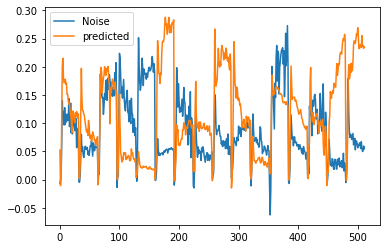

<Figure size 1440x1080 with 0 Axes>

In [ ]:
with open('test_results_' + dl_experiments[0] + '.pkl', 'rb') as input:
    test_DRNN = pickle.load(input)

[X_test, y_test, y_pred] = test_DRNN

np.savetxt("ypred_DRNN.csv", np.squeeze(y_pred), delimiter=",")

plt.plot(X_test[1], label = "Noise")
#plt.plot(y_test[2], label = " orignal")
plt.plot(y_pred[2], label = "predicted")
plt.legend()
plt.figure(figsize=(20,15))
plt.show()

### Training LSTM IEEE

In [ ]:
import _pickle as pickle
from datetime import datetime
import numpy as np


dl_experiments = ['LSTM IEEE']


train_time_list = []
test_time_list = []

for experiment in range(len(dl_experiments)):
    start_train = datetime.now()
    train_dl(Dataset, dl_experiments[experiment])
    end_train = datetime.now()
    train_time_list.append(end_train - start_train)

    start_test = datetime.now()
    [X_test, y_test, y_pred] = test_dl(Dataset, dl_experiments[experiment])
    end_test = datetime.now()
    test_time_list.append(end_test - start_test)

    test_results = [X_test, y_test, y_pred]

    # Save Results
    with open('test_results_' + dl_experiments[experiment] + '.pkl', 'wb') as output:  # Overwrites any existing file.
        pickle.dump(test_results, output)
    print('Results from experiment ' + dl_experiments[experiment] + ' saved')

Deep Learning pipeline: Training the model for exp LSTM IEEE

 LSTM_IEEE
 
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 512, 140)          79520     
_________________________________________________________________
dense_1 (Dense)              (None, 512, 140)          19740     
_________________________________________________________________
lstm_2 (LSTM)                (None, 512, 140)          157360    
_________________________________________________________________
dense_2 (Dense)              (None, 512, 140)          19740     
_________________________________________________________________
dense_3 (Dense)              (None, 512, 1)            141       
Total params: 276,501
Trainable params: 276,501
Non-trainable params: 0
_________________________________________________________________
Train on 14000 samples, validate on 600

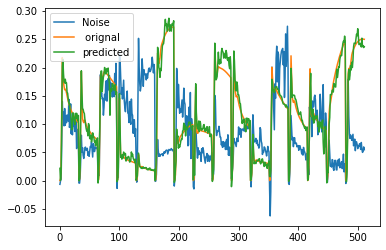

<Figure size 1440x1080 with 0 Axes>

In [ ]:
with open('test_results_' + dl_experiments[0] + '.pkl', 'rb') as input:
    test_LSTM_IEEE = pickle.load(input)

[X_test, y_test, y_pred] = test_LSTM_IEEE


plt.plot(X_test[1], label = "Noise")
plt.plot(y_test[2], label = " orignal")
plt.plot(y_pred[2], label = "predicted")
plt.legend()
plt.figure(figsize=(20,15))
plt.show()

### Training CNN IEEE

In [ ]:
import _pickle as pickle
from datetime import datetime
import numpy as np


dl_experiments = ['CNN IEEE']


train_time_list = []
test_time_list = []

for experiment in range(len(dl_experiments)):
    start_train = datetime.now()
    train_dl(Dataset, dl_experiments[experiment])
    end_train = datetime.now()
    train_time_list.append(end_train - start_train)

    start_test = datetime.now()
    [X_test, y_test, y_pred] = test_dl(Dataset, dl_experiments[experiment])
    end_test = datetime.now()
    test_time_list.append(end_test - start_test)

    test_results = [X_test, y_test, y_pred]

    # Save Results
    with open('test_results_' + dl_experiments[experiment] + '.pkl', 'wb') as output:  # Overwrites any existing file.
        pickle.dump(test_results, output)
    print('Results from experiment ' + dl_experiments[experiment] + ' saved')

Deep Learning pipeline: Training the model for exp CNN IEEE



/usr/local/lib/python3.7/dist-packages/keras/activations.py:235: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))



 CNN_IEEE
 
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 512, 1)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 512, 36)           720       
_________________________________________________________________
batch_normalization_1 (Batch (None, 512, 36)           144       
_________________________________________________________________
activation_1 (Activation)    (None, 512, 36)           0         
_________________________________________________________________
average_pooling1d_1 (Average (None, 128, 36)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 128, 36)           24660     
_________________________________________________________________
batch_normalization_2 (Batch (None, 128, 36)  

/usr/local/lib/python3.7/dist-packages/keras/activations.py:235: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))



 CNN_IEEE
 
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 512, 1)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 512, 36)           720       
_________________________________________________________________
batch_normalization_1 (Batch (None, 512, 36)           144       
_________________________________________________________________
activation_1 (Activation)    (None, 512, 36)           0         
_________________________________________________________________
average_pooling1d_1 (Average (None, 128, 36)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 128, 36)           24660     
_________________________________________________________________
batch_normalization_2 (Batch (None, 128, 36)  

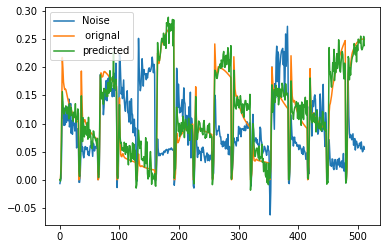

<Figure size 1440x1080 with 0 Axes>

In [ ]:
with open('test_results_' + dl_experiments[0] + '.pkl', 'rb') as input:
    test_CNN_IEEE = pickle.load(input)

[X_test, y_test, y_pred] = test_CNN_IEEE


plt.plot(X_test[1], label = "Noise")
plt.plot(y_test[2], label = " orignal")
plt.plot(y_pred[2], label = "predicted")
plt.legend()
plt.figure(figsize=(20,15))
plt.show()

### Training FCN DAE

In [ ]:
import _pickle as pickle
from datetime import datetime
import numpy as np


dl_experiments = ['FCN-DAE']


train_time_list = []
test_time_list = []

for experiment in range(len(dl_experiments)):
    start_train = datetime.now()
    train_dl(Dataset, dl_experiments[experiment])
    end_train = datetime.now()
    train_time_list.append(end_train - start_train)

    start_test = datetime.now()
    [X_test, y_test, y_pred] = test_dl(Dataset, dl_experiments[experiment])
    end_test = datetime.now()
    test_time_list.append(end_test - start_test)

    test_results = [X_test, y_test, y_pred]

    # Save Results
    with open('test_results_' + dl_experiments[experiment] + '.pkl', 'wb') as output:  # Overwrites any existing file.
        pickle.dump(test_results, output)
    print('Results from experiment ' + dl_experiments[experiment] + ' saved')

Deep Learning pipeline: Training the model for exp FCN-DAE

 FCN_DAE
 
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 512, 1)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 256, 40)           680       
_________________________________________________________________
batch_normalization_1 (Batch (None, 256, 40)           160       
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 128, 20)           12820     
_________________________________________________________________
batch_normalization_2 (Batch (None, 128, 20)           80        
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 64, 20)            6420      
______________________________________________________

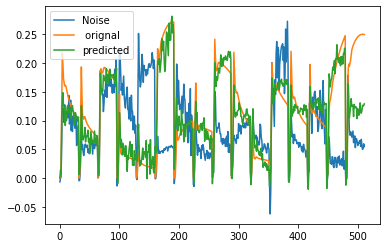

<Figure size 1440x1080 with 0 Axes>

In [ ]:
with open('test_results_' + dl_experiments[0] + '.pkl', 'rb') as input:
    test_FCN_DAE = pickle.load(input)

[X_test, y_test, y_pred] = test_FCN_DAE


plt.plot(X_test[1], label = "Noise")
plt.plot(y_test[2], label = " orignal")
plt.plot(y_pred[2], label = "predicted")
plt.legend()
plt.figure(figsize=(20,15))
plt.show()

### CNN autoencoder

In [ ]:
import _pickle as pickle
from datetime import datetime
import numpy as np


dl_experiments = ['CNN autoencoder']


train_time_list = []
test_time_list = []

for experiment in range(len(dl_experiments)):
    start_train = datetime.now()
    train_dl(Dataset, dl_experiments[experiment])
    end_train = datetime.now()
    train_time_list.append(end_train - start_train)

    start_test = datetime.now()
    [X_test, y_test, y_pred] = test_dl(Dataset, dl_experiments[experiment])
    end_test = datetime.now()
    test_time_list.append(end_test - start_test)

    test_results = [X_test, y_test, y_pred]

    # Save Results
    with open('test_results_' + dl_experiments[experiment] + '.pkl', 'wb') as output:  # Overwrites any existing file.
        pickle.dump(test_results, output)
    print('Results from experiment ' + dl_experiments[experiment] + ' saved')

### Training Vanilla L

In [ ]:
import _pickle as pickle
from datetime import datetime
import numpy as np


dl_experiments = ['Vanilla L']


train_time_list = []
test_time_list = []

for experiment in range(len(dl_experiments)):
    start_train = datetime.now()
    train_dl(Dataset, dl_experiments[experiment])
    end_train = datetime.now()
    train_time_list.append(end_train - start_train)

    start_test = datetime.now()
    [X_test, y_test, y_pred] = test_dl(Dataset, dl_experiments[experiment])
    end_test = datetime.now()
    test_time_list.append(end_test - start_test)

    test_results = [X_test, y_test, y_pred]

    # Save Results
    with open('test_results_' + dl_experiments[experiment] + '.pkl', 'wb') as output:  # Overwrites any existing file.
        pickle.dump(test_results, output)
    print('Results from experiment ' + dl_experiments[experiment] + ' saved')

Deep Learning pipeline: Training the model for exp Vanilla L




 Vanilla_L
 
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 512, 64)           640       
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 512, 64)           36928     
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 512, 32)           18464     
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 512, 32)           9248      
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 512, 16)           4624      
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 512, 16)           2320      
__________________________________________

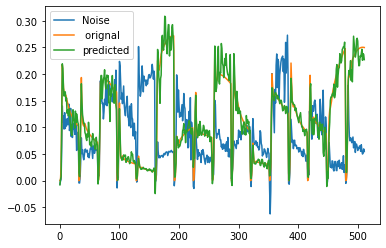

<Figure size 1440x1080 with 0 Axes>

In [ ]:
with open('test_results_' + dl_experiments[0] + '.pkl', 'rb') as input:
    test_VanillaL = pickle.load(input)

[X_test, y_test, y_pred] = test_VanillaL


plt.plot(X_test[1], label = "Noise")
plt.plot(y_test[2], label = " orignal")
plt.plot(y_pred[2], label = "predicted")
plt.legend()
plt.figure(figsize=(20,15))
plt.show()

### Vanilla NL

In [ ]:
import _pickle as pickle
from datetime import datetime
import numpy as np


dl_experiments = ['Vanilla NL']


train_time_list = []
test_time_list = []

for experiment in range(len(dl_experiments)):
    start_train = datetime.now()
    train_dl(Dataset, dl_experiments[experiment])
    end_train = datetime.now()
    train_time_list.append(end_train - start_train)

    start_test = datetime.now()
    [X_test, y_test, y_pred] = test_dl(Dataset, dl_experiments[experiment])
    end_test = datetime.now()
    test_time_list.append(end_test - start_test)

    test_results = [X_test, y_test, y_pred]

    # Save Results
    with open('test_results_' + dl_experiments[experiment] + '.pkl', 'wb') as output:  # Overwrites any existing file.
        pickle.dump(test_results, output)
    print('Results from experiment ' + dl_experiments[experiment] + ' saved')

Deep Learning pipeline: Training the model for exp Vanilla NL

 Vanilla_NL
 
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 512, 64)           640       
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 512, 64)           36928     
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 512, 32)           18464     
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 512, 32)           9248      
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 512, 16)           4624      
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 512, 16)           2320      
___________________________________________

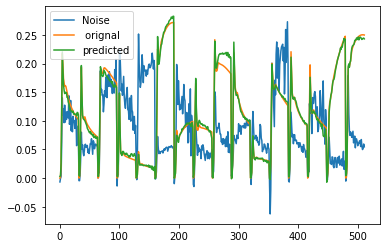

<Figure size 1440x1080 with 0 Axes>

In [ ]:
with open('test_results_' + dl_experiments[0] + '.pkl', 'rb') as input:
    test_VanillaNL = pickle.load(input)

[X_test, y_test, y_pred] = test_VanillaNL


plt.plot(X_test[1], label = "Noise")
plt.plot(y_test[2], label = " orignal")
plt.plot(y_pred[2], label = "predicted")
plt.legend()
plt.figure(figsize=(20,15))
plt.show()

### Training Multibranch LANL

In [ ]:
import _pickle as pickle
from datetime import datetime
import numpy as np


dl_experiments = ['Multibranch LANL']


train_time_list = []
test_time_list = []

for experiment in range(len(dl_experiments)):
    start_train = datetime.now()
    train_dl(Dataset, dl_experiments[experiment])
    end_train = datetime.now()
    train_time_list.append(end_train - start_train)

    start_test = datetime.now()
    [X_test, y_test, y_pred] = test_dl(Dataset, dl_experiments[experiment])
    end_test = datetime.now()
    test_time_list.append(end_test - start_test)

    test_results = [X_test, y_test, y_pred]

    # Save Results
    with open('test_results_' + dl_experiments[experiment] + '.pkl', 'wb') as output:  # Overwrites any existing file.
        pickle.dump(test_results, output)

Deep Learning pipeline: Training the model for exp Multibranch LANL

 Multibranch_LANL
 
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 512, 1)       0                                            
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 512, 8)       32          input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 512, 8)       48          input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_3 (Conv1D)               (None, 512, 8)       80          input_1[0][0]                    
___

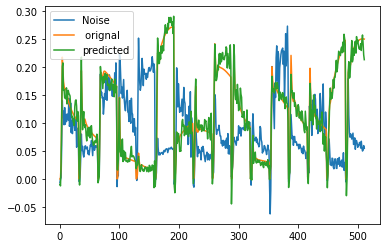

<Figure size 1440x1080 with 0 Axes>

In [ ]:
with open('test_results_' + dl_experiments[0] + '.pkl', 'rb') as input:
    test_Multibranch_LANL = pickle.load(input)

[X_test, y_test, y_pred] = test_Multibranch_LANL


plt.plot(X_test[1], label = "Noise")
plt.plot(y_test[2], label = " orignal")
plt.plot(y_pred[2], label = "predicted")
plt.legend()
plt.figure(figsize=(20,15))
plt.show()

## Plot Results

In [16]:
####### LOAD EXPERIMENTS #######
import pickle
dl_experiments = ['FCN-DAE', 'DRNN',  'LSTM IEEE', 'CNN IEEE', 'Vanilla L', 'Vanilla NL', 'Multibranch LANL']

# Load Results DRNN
with open('drive/MyDrive/test_results_' + dl_experiments[0] + '.pkl', 'rb') as input:
    test_DRNN = pickle.load(input)

# Load Results FCN_DAE
with open('drive/MyDrive/test_results_' + dl_experiments[1] + '.pkl', 'rb') as input:
    test_FCN_DAE = pickle.load(input)

# Load Results LSTM IEEE
with open('drive/MyDrive/test_results_' + dl_experiments[2] + '.pkl', 'rb') as input:
    test_LSTM_IEEE = pickle.load(input)

# Load Results Exp CNN IEEE
with open('drive/MyDrive/test_results_CNN IEEE(1).pkl', 'rb') as input:
    test_CNN_IEEE = pickle.load(input)

# Load Results Vanilla L
with open('drive/MyDrive/test_results_' + dl_experiments[4] + '.pkl', 'rb') as input:
    test_Vanilla_L = pickle.load(input)

# Load Results Exp Vanilla NL
with open('drive/MyDrive/test_results_' + dl_experiments[5] + '.pkl', 'rb') as input:
    test_Vanilla_NL = pickle.load(input)

# Load Results Multibranch LANL
with open('drive/MyDrive/test_results_' + dl_experiments[6] + '.pkl', 'rb') as input:
    test_Multibranch_LANL = pickle.load(input)

####### Calculate Metrics #######

print('Calculating metrics ...')
SSD_data = SSD(X_test, y_test)
MAD_data = MAD(X_test, y_test)
PRD_data = PRD(X_test, y_test)
COS_SIM_data = COS_SIM(X_test, y_test)


# DL Metrics

# Exp DRNN

[X_test, y_test, y_pred] = test_DRNN

SSD_values_DL_DRNN = SSD(y_test, y_pred)

MAD_values_DL_DRNN = MAD(y_test, y_pred)

PRD_values_DL_DRNN = PRD(y_test, y_pred)

COS_SIM_values_DL_DRNN = COS_SIM(y_test, y_pred)

# Exp FCN-DAE

[X_test, y_test, y_pred] = test_FCN_DAE

SSD_values_DL_FCN_DAE = SSD(y_test, y_pred)

MAD_values_DL_FCN_DAE = MAD(y_test, y_pred)

PRD_values_DL_FCN_DAE = PRD(y_test, y_pred)

COS_SIM_values_DL_FCN_DAE = COS_SIM(y_test, y_pred)

# Exp LSTM IEEE

[X_test, y_test, y_pred] = test_LSTM_IEEE

SSD_values_DL_LSTM_IEEE = SSD(y_test, y_pred)

MAD_values_DL_LSTM_IEEE = MAD(y_test, y_pred)

PRD_values_DL_LSTM_IEEE = PRD(y_test, y_pred)

COS_SIM_values_DL_LSTM_IEEE = COS_SIM(y_test, y_pred)

# Exp CNN IEEE

[X_test, y_test, y_pred] = test_CNN_IEEE

SSD_values_DL_CNN_IEEE = SSD(y_test, y_pred)

MAD_values_DL_CNN_IEEE = MAD(y_test, y_pred)

PRD_values_DL_CNN_IEEE = PRD(y_test, y_pred)

COS_SIM_values_DL_CNN_IEEE = COS_SIM(y_test, y_pred)

# Vanilla L

[X_test, y_test, y_pred] = test_Vanilla_L

SSD_values_DL_exp_1 = SSD(y_test, y_pred)

MAD_values_DL_exp_1 = MAD(y_test, y_pred)

PRD_values_DL_exp_1 = PRD(y_test, y_pred)

COS_SIM_values_DL_exp_1 = COS_SIM(y_test, y_pred)

# Vanilla_NL

[X_test, y_test, y_pred] = test_Vanilla_NL

SSD_values_DL_exp_2 = SSD(y_test, y_pred)

MAD_values_DL_exp_2 = MAD(y_test, y_pred)

PRD_values_DL_exp_2 = PRD(y_test, y_pred)

COS_SIM_values_DL_exp_2 = COS_SIM(y_test, y_pred)

# Multibranch_LANL

[X_test, y_test, y_pred] = test_Multibranch_LANL

SSD_values_DL_exp_3 = SSD(y_test, y_pred)

MAD_values_DL_exp_3 = MAD(y_test, y_pred)

PRD_values_DL_exp_3 = PRD(y_test, y_pred)

COS_SIM_values_DL_exp_3 = COS_SIM(y_test, y_pred)


SSD_all = [SSD_data,
           SSD_values_DL_FCN_DAE,
           SSD_values_DL_DRNN,
           SSD_values_DL_LSTM_IEEE,
           SSD_values_DL_CNN_IEEE,
           SSD_values_DL_exp_1,
           SSD_values_DL_exp_2,
           SSD_values_DL_exp_3,
           ]

MAD_all = [MAD_data,
           MAD_values_DL_FCN_DAE,
           MAD_values_DL_DRNN,
           MAD_values_DL_LSTM_IEEE,
           MAD_values_DL_CNN_IEEE,
           MAD_values_DL_exp_1,
           MAD_values_DL_exp_2,
           MAD_values_DL_exp_3,
           ]

PRD_all = [PRD_data,
           PRD_values_DL_FCN_DAE,
           PRD_values_DL_DRNN,
           PRD_values_DL_LSTM_IEEE,
           PRD_values_DL_CNN_IEEE,
           PRD_values_DL_exp_1,
           PRD_values_DL_exp_2,
           PRD_values_DL_exp_3,
           ]

CORR_all = [COS_SIM_data,
            COS_SIM_values_DL_FCN_DAE,
            COS_SIM_values_DL_DRNN,
            COS_SIM_values_DL_LSTM_IEEE,
            COS_SIM_values_DL_CNN_IEEE,
            COS_SIM_values_DL_exp_1,
            COS_SIM_values_DL_exp_2,
            COS_SIM_values_DL_exp_3,
            ]

Exp_names = ['Data Values'] + dl_experiments
#Exp_names = dl_experiments

metrics = ['SSD', 'MAD', 'PRD', 'COS_SIM']
metric_values = [SSD_all, MAD_all, PRD_all, CORR_all]

# Metrics table
generate_table(metrics, metric_values, Exp_names)


Calculating metrics ...


+------------------+---------------+---------------+-----------------+---------------+
|   Method/Model   |      SSD      |      MAD      |       PRD       |    COS_SIM    |
+------------------+---------------+---------------+-----------------+---------------+
|   Data Values    | 0.167 (0.063) | 0.094 (0.029) |  26.276 (4.452) | 0.990 (0.003) |
|     FCN-DAE      | 0.066 (0.024) | 0.066 (0.023) |  16.843 (2.726) | 0.996 (0.001) |
|       DRNN       | 0.338 (0.181) | 0.100 (0.034) | 39.910 (10.309) | 0.980 (0.010) |
|    LSTM IEEE     | 0.058 (0.020) | 0.064 (0.023) |  15.704 (2.561) | 0.997 (0.001) |
|     CNN IEEE     | 0.202 (0.053) | 0.085 (0.016) |  30.149 (3.583) | 0.988 (0.003) |
|    Vanilla L     | 0.102 (0.035) | 0.072 (0.019) |  21.001 (3.016) | 0.994 (0.001) |
|    Vanilla NL    | 0.018 (0.008) | 0.033 (0.014) |  8.657 (1.721)  | 0.999 (0.000) |
| Multibranch LANL | 0.089 (0.018) | 0.056 (0.015) |  19.310 (2.720) | 0.994 (0.001) |
+----------------

In [ ]:
type(SSD_all)

list

In [ ]:
TIME_all = [[1017, 2057, 6485 , 287 , 1144 , 1284, 10930 ]]
time_metric = ['Training Time']
generate_table(time_metric, TIME_all, Exp_names)



+------------------+-------------------+
|   Method/Model   |   Training Time   |
+------------------+-------------------+
|       DRNN       |  1017.000 (0.000) |
|     FCN-DAE      |  2057.000 (0.000) |
|    LSTM IEEE     |  6485.000 (0.000) |
|     CNN IEEE     |  287.000 (0.000)  |
|    Vanilla L     |  1144.000 (0.000) |
|    Vanilla NL    |  1284.000 (0.000) |
| Multibranch LANL | 10930.000 (0.000) |
+------------------+-------------------+


In [48]:
type(SSD_all[0])

SSD_alln = SSD_all
for i in range(len(SSD_alln)):
  SSD_alln[i] = np.squeeze(SSD_alln[i]).tolist()

In [49]:
loss_val_np = np.rot90(SSD_alln)
pd_df = pd.DataFrame.from_records(loss_val_np, columns=Exp_names)
pd_df.head()

FCN-DAE      DRNN  LSTM IEEE  ...  Vanilla L  Vanilla NL  Multibranch LANL
0  0.038784  0.372293   0.030734  ...   0.065183    0.008919          0.070585
1  0.049136  0.407458   0.040327  ...   0.093920    0.014884          0.097609
2  0.090338  0.294554   0.086004  ...   0.147013    0.033023          0.127050
3  0.055783  0.575764   0.050623  ...   0.082505    0.013194          0.071820
4  0.055919  0.290756   0.046703  ...   0.090834    0.013524          0.073307

[5 rows x 7 columns]

### SSD boxplot

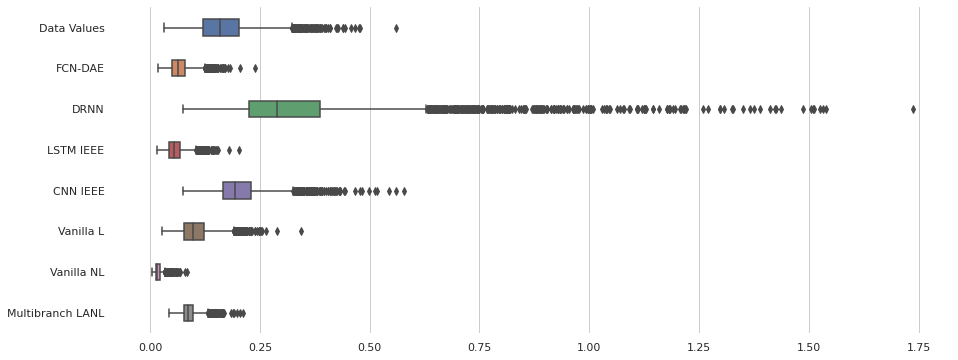

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="whitegrid")
f, ax = plt.subplots(figsize=(15, 6))
SSD_alln = SSD_all

for i in range(len(SSD_alln)):
  SSD_alln[i] = np.squeeze(SSD_alln[i]).tolist()

loss_val_np = np.rot90(SSD_alln)
pd_df = pd.DataFrame.from_records(loss_val_np, columns=Exp_names)

ax = sns.boxplot(data=pd_df, orient="h", width=0.4)
ax = sns.despine(left=True, bottom=True)

plt.show()

#sns.boxplot(data=all_arr)


### MAD boxplot

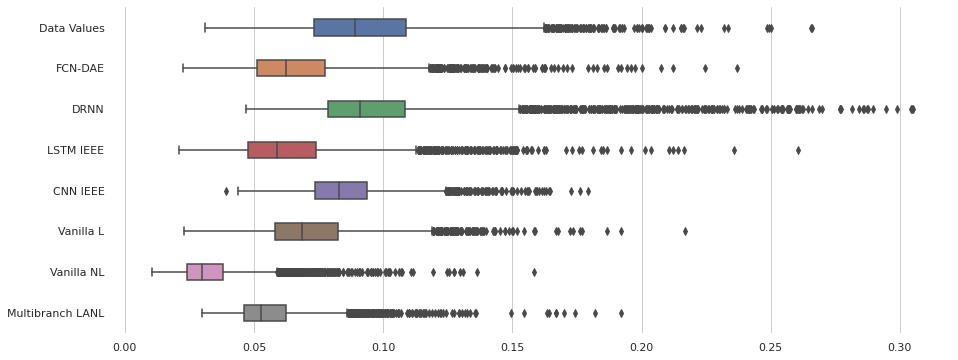

In [18]:
f, ax = plt.subplots(figsize=(15, 6))
SSD_alln = MAD_all

for i in range(len(SSD_alln)):
  SSD_alln[i] = np.squeeze(SSD_alln[i]).tolist()

loss_val_np = np.rot90(SSD_alln)
pd_df = pd.DataFrame.from_records(loss_val_np, columns=Exp_names)

ax = sns.boxplot(data=pd_df, orient="h", width=0.4)
ax = sns.despine(left=True, bottom=True)

plt.show()

#sns.boxplot(data=all_arr)


### PRD boxplot

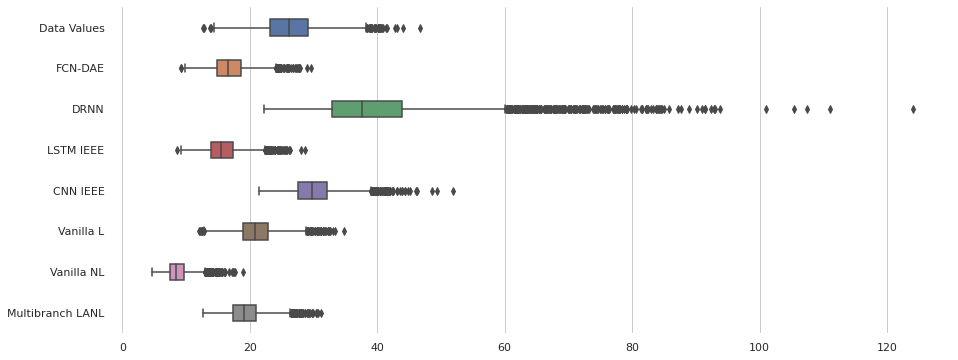

In [19]:
f, ax = plt.subplots(figsize=(15, 6))
SSD_alln = PRD_all

for i in range(len(SSD_alln)):
  SSD_alln[i] = np.squeeze(SSD_alln[i]).tolist()

loss_val_np = np.rot90(SSD_alln)
pd_df = pd.DataFrame.from_records(loss_val_np, columns=Exp_names)

ax = sns.boxplot(data=pd_df, orient="h", width=0.4)
ax = sns.despine(left=True, bottom=True)

plt.show()

#sns.boxplot(data=all_arr)


### Corr Boxplot

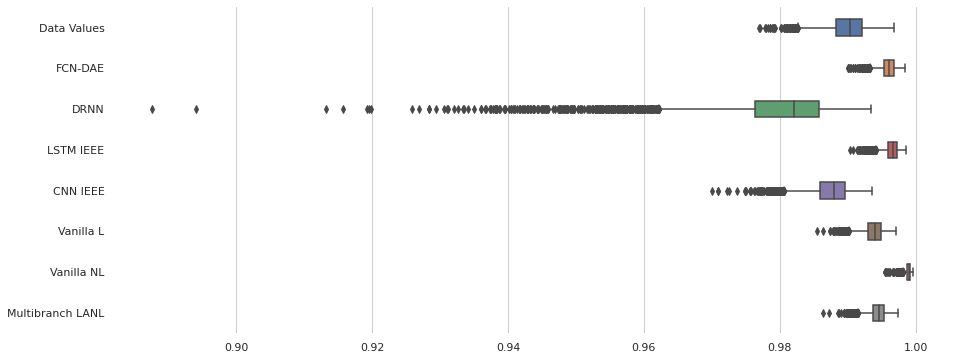

In [20]:
f, ax = plt.subplots(figsize=(15, 6))
SSD_alln = CORR_all

for i in range(len(SSD_alln)):
  SSD_alln[i] = np.squeeze(SSD_alln[i]).tolist()

loss_val_np = np.rot90(SSD_alln)
pd_df = pd.DataFrame.from_records(loss_val_np, columns=Exp_names)

ax = sns.boxplot(data=pd_df, orient="h", width=0.4)
ax = sns.despine(left=True, bottom=True)

plt.show()

#sns.boxplot(data=all_arr)


## Visualize Results

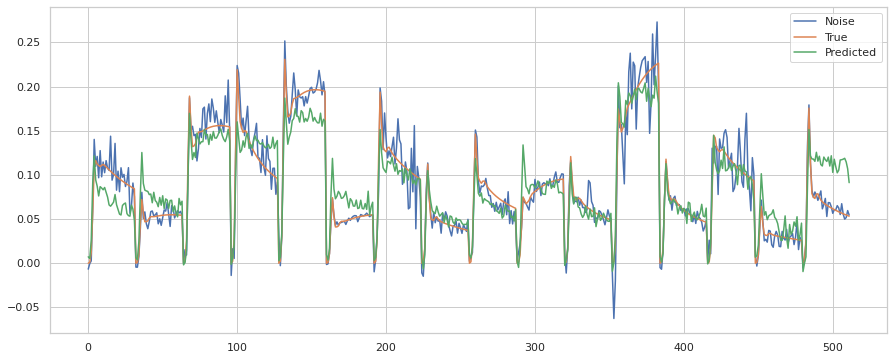

In [57]:
# Load Results DRNN
with open('drive/MyDrive/test_results_' + dl_experiments[0] + '.pkl', 'rb') as input:
    test_DRNN = pickle.load(input)

[X_test, y_test, y_pred_DRNN] = test_DRNN

f, ax = plt.subplots(figsize=(15, 6))
ax = plt.plot(X_test[1], label = 'Noise')
ax = plt.plot(y_test[1], label = 'True')
ax = plt.plot(y_pred_DRNN[1], label = 'Predicted')


plt.legend()
plt.show()


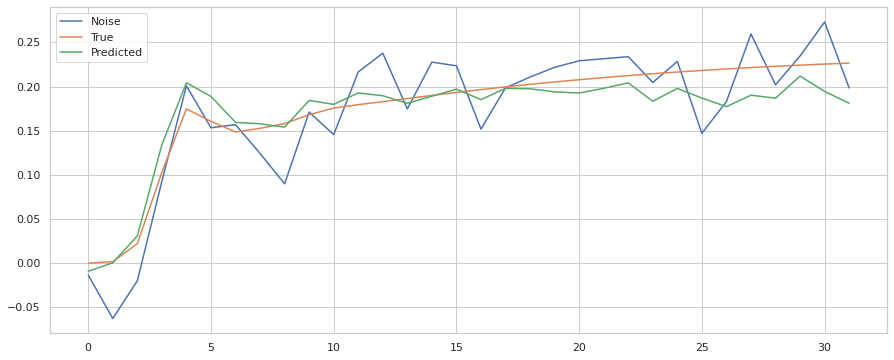

In [60]:
f, ax = plt.subplots(figsize=(15, 6))
ax = plt.plot(X_test[1][352:384], label = 'Noise')
ax = plt.plot(y_test[1][352:384], label = 'True')
ax = plt.plot(y_pred_DRNN[1][352:384], label = 'Predicted')


plt.legend()
plt.show()

In [8]:
dl_experiments

['FCN-DAE',
 'DRNN',
 'LSTM IEEE',
 'CNN IEEE',
 'Vanilla L',
 'Vanilla NL',
 'Multibranch LANL']

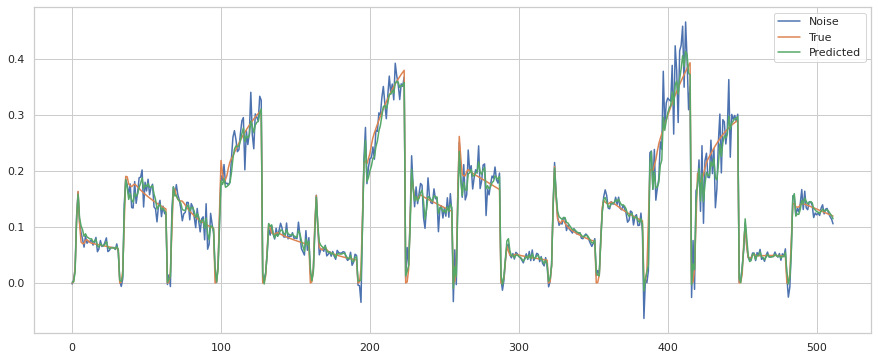

In [41]:
# FN-DAE
with open('drive/MyDrive/test_results_' + dl_experiments[1] + '.pkl', 'rb') as input:
    test_DRNN = pickle.load(input)

[X_test, y_test, y_pred_DRNN] = test_DRNN

f, ax = plt.subplots(figsize=(15, 6))
ax = plt.plot(X_test[5], label = 'Noise')
ax = plt.plot(y_test[5], label = 'True')
ax = plt.plot(y_pred_DRNN[5], label = 'Predicted')


plt.legend()
plt.show()

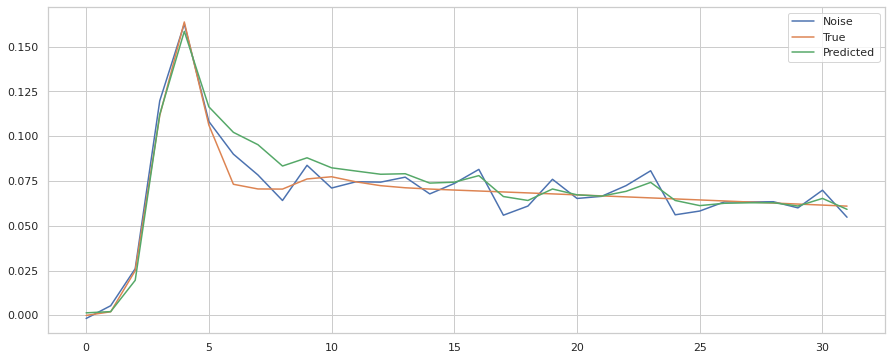

In [42]:
f, ax = plt.subplots(figsize=(15, 6))
ax = plt.plot(X_test[5][0:32], label = 'Noise')
ax = plt.plot(y_test[5][0:32], label = 'True')
ax = plt.plot(y_pred_DRNN[5][0:32], label = 'Predicted')


plt.legend()
plt.show()

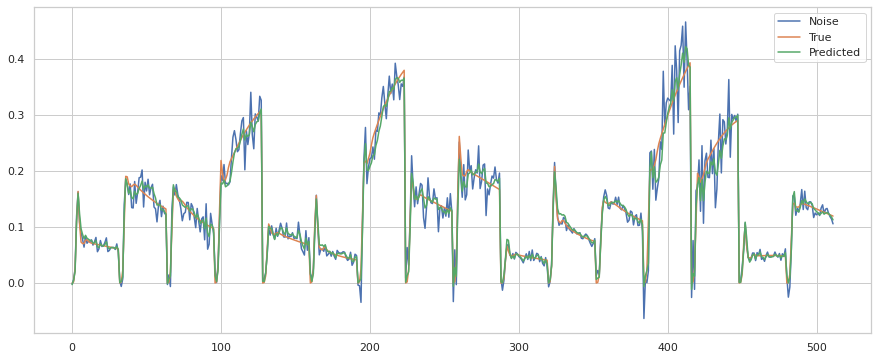

In [25]:
#LSTM-IEEE
with open('drive/MyDrive/test_results_' + dl_experiments[2] + '.pkl', 'rb') as input:
    test_DRNN = pickle.load(input)

[X_test, y_test, y_pred_DRNN] = test_DRNN

f, ax = plt.subplots(figsize=(15, 6))
ax = plt.plot(X_test[5], label = 'Noise')
ax = plt.plot(y_test[5], label = 'True')
ax = plt.plot(y_pred_DRNN[5], label = 'Predicted')


plt.legend()
plt.show()

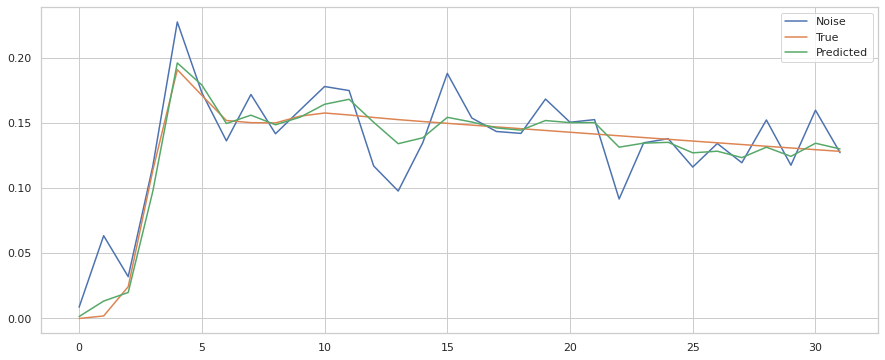

In [24]:
f, ax = plt.subplots(figsize=(15, 6))
ax = plt.plot(X_test[5][st:end], label = 'Noise')
ax = plt.plot(y_test[5][st:end], label = 'True')
ax = plt.plot(y_pred_DRNN[5][st:end], label = 'Predicted')


plt.legend()
plt.show()

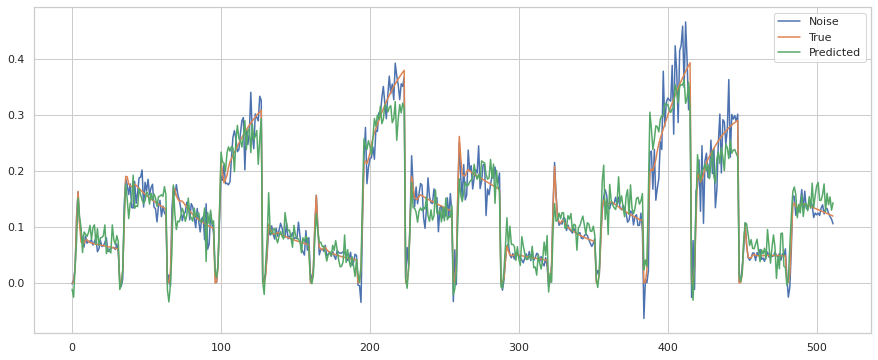

In [30]:
#CNN-IEEE
with open('drive/MyDrive/test_results_' + dl_experiments[3] + '(1).pkl', 'rb') as input:
    test_DRNN = pickle.load(input)

[X_test, y_test, y_pred_DRNN] = test_DRNN

f, ax = plt.subplots(figsize=(15, 6))
ax = plt.plot(X_test[5], label = 'Noise')
ax = plt.plot(y_test[5], label = 'True')
ax = plt.plot(y_pred_DRNN[5], label = 'Predicted')


plt.legend()
plt.show()

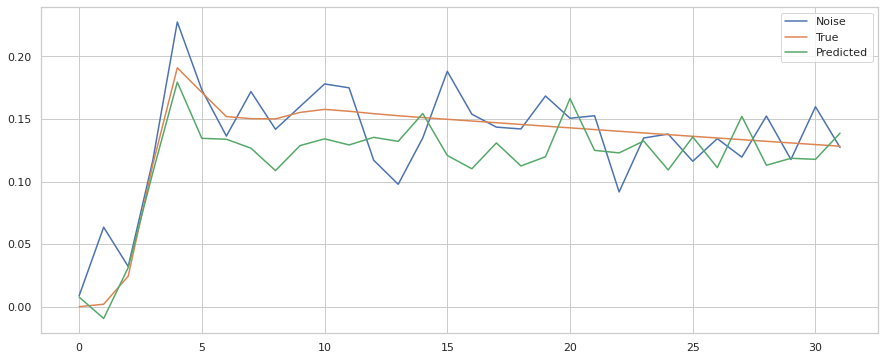

In [32]:
f, ax = plt.subplots(figsize=(15, 6))
ax = plt.plot(X_test[5][st:end], label = 'Noise')
ax = plt.plot(y_test[5][st:end], label = 'True')
ax = plt.plot(y_pred_DRNN[5][st:end], label = 'Predicted')


plt.legend()
plt.show()

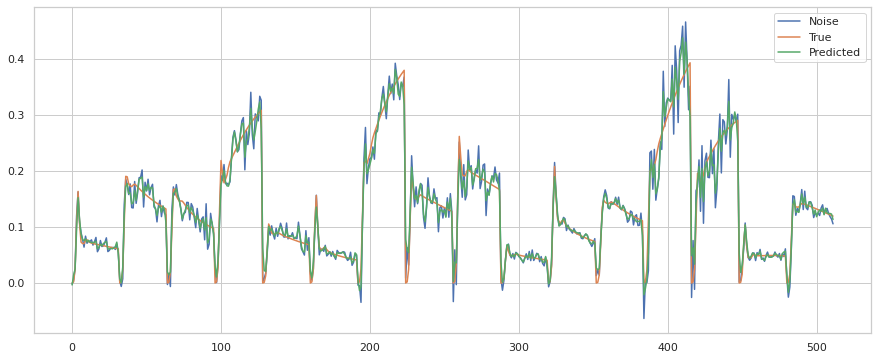

In [34]:
#Vanilla L
with open('drive/MyDrive/test_results_' + dl_experiments[4] + '.pkl', 'rb') as input:
    test_DRNN = pickle.load(input)

[X_test, y_test, y_pred_DRNN] = test_DRNN

f, ax = plt.subplots(figsize=(15, 6))
ax = plt.plot(X_test[5], label = 'Noise')
ax = plt.plot(y_test[5], label = 'True')
ax = plt.plot(y_pred_DRNN[5], label = 'Predicted')


plt.legend()
plt.show()

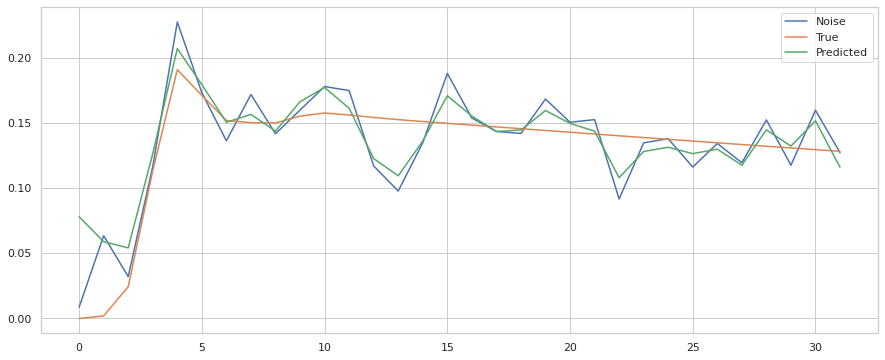

In [35]:
f, ax = plt.subplots(figsize=(15, 6))
ax = plt.plot(X_test[5][st:end], label = 'Noise')
ax = plt.plot(y_test[5][st:end], label = 'True')
ax = plt.plot(y_pred_DRNN[5][st:end], label = 'Predicted')


plt.legend()
plt.show()

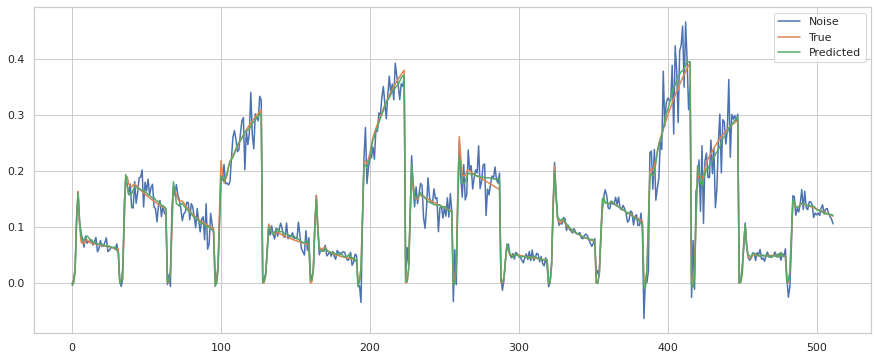

In [36]:
#Vanilla NL
with open('drive/MyDrive/test_results_' + dl_experiments[5] + '.pkl', 'rb') as input:
    test_DRNN = pickle.load(input)

[X_test, y_test, y_pred_DRNN] = test_DRNN

f, ax = plt.subplots(figsize=(15, 6))
ax = plt.plot(X_test[5], label = 'Noise')
ax = plt.plot(y_test[5], label = 'True')
ax = plt.plot(y_pred_DRNN[5], label = 'Predicted')


plt.legend()
plt.show()

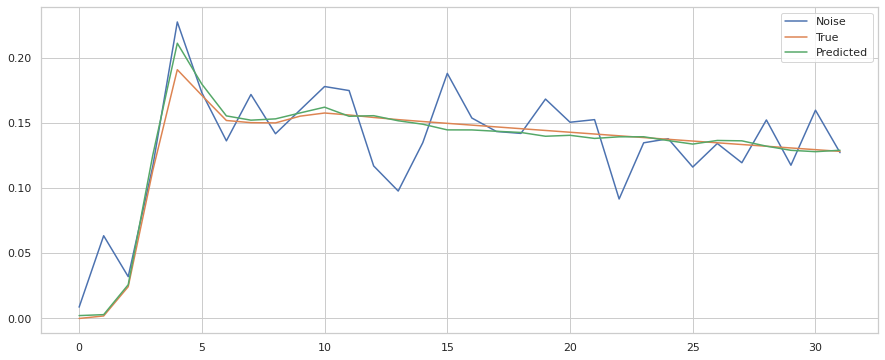

In [37]:
f, ax = plt.subplots(figsize=(15, 6))
ax = plt.plot(X_test[5][st:end], label = 'Noise')
ax = plt.plot(y_test[5][st:end], label = 'True')
ax = plt.plot(y_pred_DRNN[5][st:end], label = 'Predicted')


plt.legend()
plt.show()

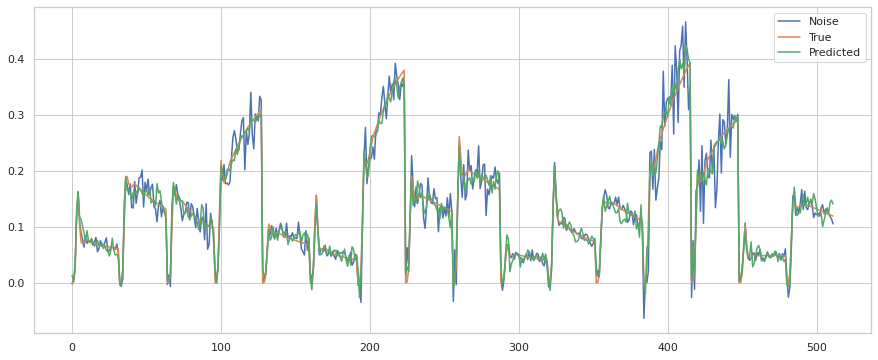

In [39]:
#Multilandl
with open('drive/MyDrive/test_results_' + dl_experiments[6] + '.pkl', 'rb') as input:
    test_DRNN = pickle.load(input)

[X_test, y_test, y_pred_DRNN] = test_DRNN

f, ax = plt.subplots(figsize=(15, 6))
ax = plt.plot(X_test[5], label = 'Noise')
ax = plt.plot(y_test[5], label = 'True')
ax = plt.plot(y_pred_DRNN[5], label = 'Predicted')


plt.legend()
plt.show()

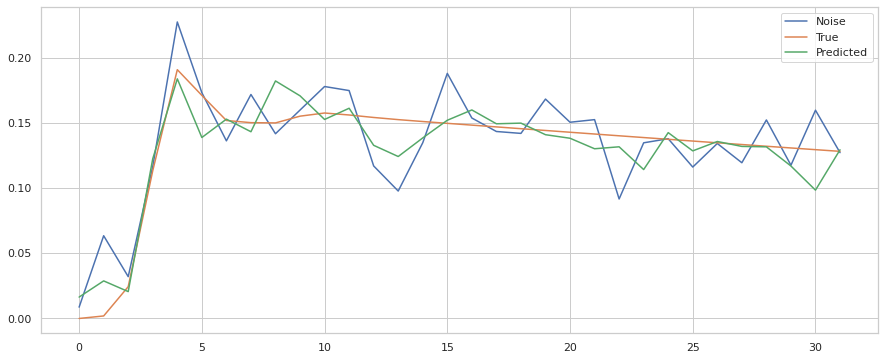

In [40]:
f, ax = plt.subplots(figsize=(15, 6))
ax = plt.plot(X_test[5][st:end], label = 'Noise')
ax = plt.plot(y_test[5][st:end], label = 'True')
ax = plt.plot(y_pred_DRNN[5][st:end], label = 'Predicted')


plt.legend()
plt.show()

In [22]:
st = 256-32
end = 256

In [26]:
import datetime
from datetime import date
import pandas as pd
import numpy as np
from plotly import __version__
%matplotlib inline

import plotly.offline as pyo
import plotly.graph_objs as go
from plotly.offline import iplot

import cufflinks as cf
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot 


cf.go_offline()

init_notebook_mode(connected=False)

def configure_plotly_browser_state():
  import IPython
  display(IPython.core.display.HTML('''
        <script src="/static/components/requirejs/require.js"></script>
        <script>
          requirejs.config({
            paths: {
              base: '/static/base',
              plotly: 'https://cdn.plot.ly/plotly-1.5.1.min.js?noext',
            },
          });
        </script>
        '''))
  

In [27]:
pd_df.head()

Data Values   FCN-DAE      DRNN  ...  Vanilla L  Vanilla NL  Multibranch LANL
0     0.993583  0.997442  0.974697  ...   0.995538    0.999390          0.995194
1     0.993363  0.997646  0.982230  ...   0.995493    0.999302          0.995381
2     0.989382  0.995806  0.986609  ...   0.993324    0.998606          0.994664
3     0.993450  0.996969  0.967250  ...   0.995493    0.999334          0.995983
4     0.990067  0.995879  0.978393  ...   0.993291    0.999012          0.994588

[5 rows x 8 columns]

In [28]:
df = pd.DataFrame({
    'month': ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December'],
    'Year_2018': [3.26, 6.11, 4.86, 6.53, 4.45, 3.86, 8.04, 7.59, 1.48, 4.75, 7.27, 11.83],
    'Year_1996': [8.26, 3.82, 6.42, 2.91, 2.12, 1.70, 2.14, 4.66, 4.32, 0.89, 3.22, 4.14]
}
)
df.head()

month  Year_2018  Year_1996
0   January       3.26       8.26
1  February       6.11       3.82
2     March       4.86       6.42
3     April       6.53       2.91
4       May       4.45       2.12